In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')



In [2]:
class CustomerClusteringAnalysis:
    def __init__(self, customers_path, transactions_path):
        """Initialize with paths to data files"""
        self.customers_path = customers_path
        self.transactions_path = transactions_path
        self.features = None
        self.normalized_data = None
        self.merged_df = None
        self.clustering_results = {}

    def load_and_preprocess_data(self):
        """Load and preprocess customer and transaction data"""
        # Load data
        customers_df = pd.read_csv(self.customers_path)
        transactions_df = pd.read_csv(self.transactions_path)
        
        # Merge datasets
        self.merged_df = pd.merge(customers_df, transactions_df, on='CustomerID')
        
        # Select features
        self.features = self.merged_df[['Quantity', 'TotalValue', 'Price', 'Region', 'SignupDate']]
        self.features = self.features.dropna()
        
        # Encode categorical features
        label_encoder = LabelEncoder()
        self.features['Region_Encoded'] = label_encoder.fit_transform(self.features['Region'])
        self.features['SignupDate_Numeric'] = pd.to_datetime(self.features['SignupDate']).apply(lambda x: x.toordinal())
        
        # Select numeric features
        numeric_features = self.features[['Quantity', 'TotalValue', 'Price', 'Region_Encoded', 'SignupDate_Numeric']]
        
        # Standardize features
        scaler = StandardScaler()
        self.normalized_data = scaler.fit_transform(numeric_features)
        
        return self.features, self.normalized_data

    def evaluate_optimal_clusters(self, max_clusters=10):
        """Evaluate optimal number of clusters"""
        k_values = range(2, max_clusters + 1)
        metrics = {
            'db_scores': [],
            'silhouette_scores': [],
            'calinski_scores': []
        }
        
        for k in k_values:
            kmeans = KMeans(n_clusters=k, random_state=42)
            labels = kmeans.fit_predict(self.normalized_data)
            
            metrics['db_scores'].append(davies_bouldin_score(self.normalized_data, labels))
            metrics['silhouette_scores'].append(silhouette_score(self.normalized_data, labels))
            metrics['calinski_scores'].append(calinski_harabasz_score(self.normalized_data, labels))
        
        # Plot metrics
        fig = make_subplots(
            rows=3, cols=1,
            subplot_titles=('Davies-Bouldin Index', 'Silhouette Score', 'Calinski-Harabasz Score')
        )
        
        fig.add_trace(
            go.Scatter(x=list(k_values), y=metrics['db_scores'], 
                      mode='lines+markers', name='Davies-Bouldin'),
            row=1, col=1
        )
        fig.add_trace(
            go.Scatter(x=list(k_values), y=metrics['silhouette_scores'], 
                      mode='lines+markers', name='Silhouette'),
            row=2, col=1
        )
        fig.add_trace(
            go.Scatter(x=list(k_values), y=metrics['calinski_scores'], 
                      mode='lines+markers', name='Calinski-Harabasz'),
            row=3, col=1
        )
        
        fig.update_layout(height=900, title_text="Clustering Evaluation Metrics", showlegend=True)
        fig.show()
        
        return metrics

    def perform_clustering(self, n_clusters):
        """Perform clustering using multiple algorithms"""
        # K-Means
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        self.clustering_results['KMeans'] = kmeans.fit_predict(self.normalized_data)
        
        # DBSCAN
        dbscan = DBSCAN(eps=0.5, min_samples=5)
        self.clustering_results['DBSCAN'] = dbscan.fit_predict(self.normalized_data)
        
        # Agglomerative
        agg = AgglomerativeClustering(n_clusters=n_clusters)
        self.clustering_results['Agglomerative'] = agg.fit_predict(self.normalized_data)
        
        # GMM
        gmm = GaussianMixture(n_components=n_clusters, random_state=42)
        self.clustering_results['GMM'] = gmm.fit_predict(self.normalized_data)
        
        # Spectral
        spectral = SpectralClustering(n_clusters=n_clusters, random_state=42)
        self.clustering_results['Spectral'] = spectral.fit_predict(self.normalized_data)
        
        return self.clustering_results

    def create_cluster_summary(self, analysis_df):
        """Create summary statistics for each cluster"""
        return analysis_df.groupby('Cluster').agg({
            'Quantity': ['mean', 'std'],
            'TotalValue': ['mean', 'std'],
            'Price': ['mean', 'std']
        }).round(2)

    def plot_quantity_distribution(self, fig, analysis_df):
        """Create quantity distribution box plot"""
        fig.add_trace(
            go.Box(
                y=analysis_df['Quantity'],
                x=analysis_df['Cluster'],
                name='Quantity',
                boxpoints='outliers',
                marker_color='blue'
            ),
            row=1, col=1
        )
        fig.update_xaxes(title_text='Cluster', row=1, col=1)
        fig.update_yaxes(title_text='Quantity', row=1, col=1)

    def plot_total_value_distribution(self, fig, analysis_df):
        """Create total value distribution box plot"""
        fig.add_trace(
            go.Box(
                y=analysis_df['TotalValue'],
                x=analysis_df['Cluster'],
                name='Total Value',
                boxpoints='outliers',
                marker_color='green'
            ),
            row=1, col=2
        )
        fig.update_xaxes(title_text='Cluster', row=1, col=2)
        fig.update_yaxes(title_text='Total Value', row=1, col=2)

    def plot_price_distribution(self, fig, analysis_df):
        """Create price distribution box plot"""
        fig.add_trace(
            go.Box(
                y=analysis_df['Price'],
                x=analysis_df['Cluster'],
                name='Price',
                boxpoints='outliers',
                marker_color='red'
            ),
            row=2, col=1
        )
        fig.update_xaxes(title_text='Cluster', row=2, col=1)
        fig.update_yaxes(title_text='Price', row=2, col=1)

    def plot_region_distribution(self, fig, analysis_df):
        """Create region distribution bar plot"""
        region_dist = analysis_df.groupby(['Cluster', 'Region']).size().unstack()
        
        for region in region_dist.columns:
            fig.add_trace(
                go.Bar(
                    x=region_dist.index,
                    y=region_dist[region],
                    name=region
                ),
                row=2, col=2
            )
        
        fig.update_xaxes(title_text='Cluster', row=2, col=2)
        fig.update_yaxes(title_text='Count', row=2, col=2)

    def create_cluster_visualization(self, analysis_df, method):
        """Create complete cluster visualization"""
        fig = make_subplots(
            rows=2, cols=2,
            subplot_titles=(
                'Quantity Distribution',
                'Total Value Distribution',
                'Price Distribution',
                'Region Distribution'
            ),
            vertical_spacing=0.12
        )
        
        self.plot_quantity_distribution(fig, analysis_df)
        self.plot_total_value_distribution(fig, analysis_df)
        self.plot_price_distribution(fig, analysis_df)
        self.plot_region_distribution(fig, analysis_df)
        
        fig.update_layout(
            height=800,
            title_text=f"Cluster Characteristics - {method}",
            showlegend=True,
            legend=dict(
                orientation="h",
                yanchor="bottom",
                y=-0.2,
                xanchor="center",
                x=0.5
            )
        )
        
        return fig

    def visualize_clusters_3d(self):
        """Create 3D visualization of clusters"""
        pca = PCA(n_components=3)
        pca_components = pca.fit_transform(self.normalized_data)
        
        for method, labels in self.clustering_results.items():
            fig = px.scatter_3d(
                x=pca_components[:, 0],
                y=pca_components[:, 1],
                z=pca_components[:, 2],
                color=labels,
                title=f'3D Cluster Visualization - {method}',
                labels={'x': 'PC1', 'y': 'PC2', 'z': 'PC3'}
            )
            fig.show()

    def analyze_cluster_characteristics(self):
        """Analyze and visualize cluster characteristics"""
        for method, labels in self.clustering_results.items():
            # Prepare analysis dataframe
            analysis_df = self.features.copy()
            analysis_df['Cluster'] = labels
            
            # Generate and print summary statistics
            cluster_summary = self.create_cluster_summary(analysis_df)
            print(f"\nCluster Summary for {method}:")
            print(cluster_summary)
            
            # Create and display visualizations
            fig = self.create_cluster_visualization(analysis_df, method)
            fig.show()

    def evaluate_clustering(self):
        """Evaluate clustering results using multiple metrics"""
        metrics = {}
        for method, labels in self.clustering_results.items():
            metrics[method] = {
                'Davies-Bouldin': davies_bouldin_score(self.normalized_data, labels),
                'Silhouette': silhouette_score(self.normalized_data, labels),
                'Calinski-Harabasz': calinski_harabasz_score(self.normalized_data, labels)
            }
        
        return pd.DataFrame(metrics).round(3)



In [11]:

# Initialize analysis
analysis = CustomerClusteringAnalysis("Customers.csv", "Transactions.csv")
    
   

In [13]:
# Load and preprocess data
features, normalized_data = analysis.load_and_preprocess_data()

    


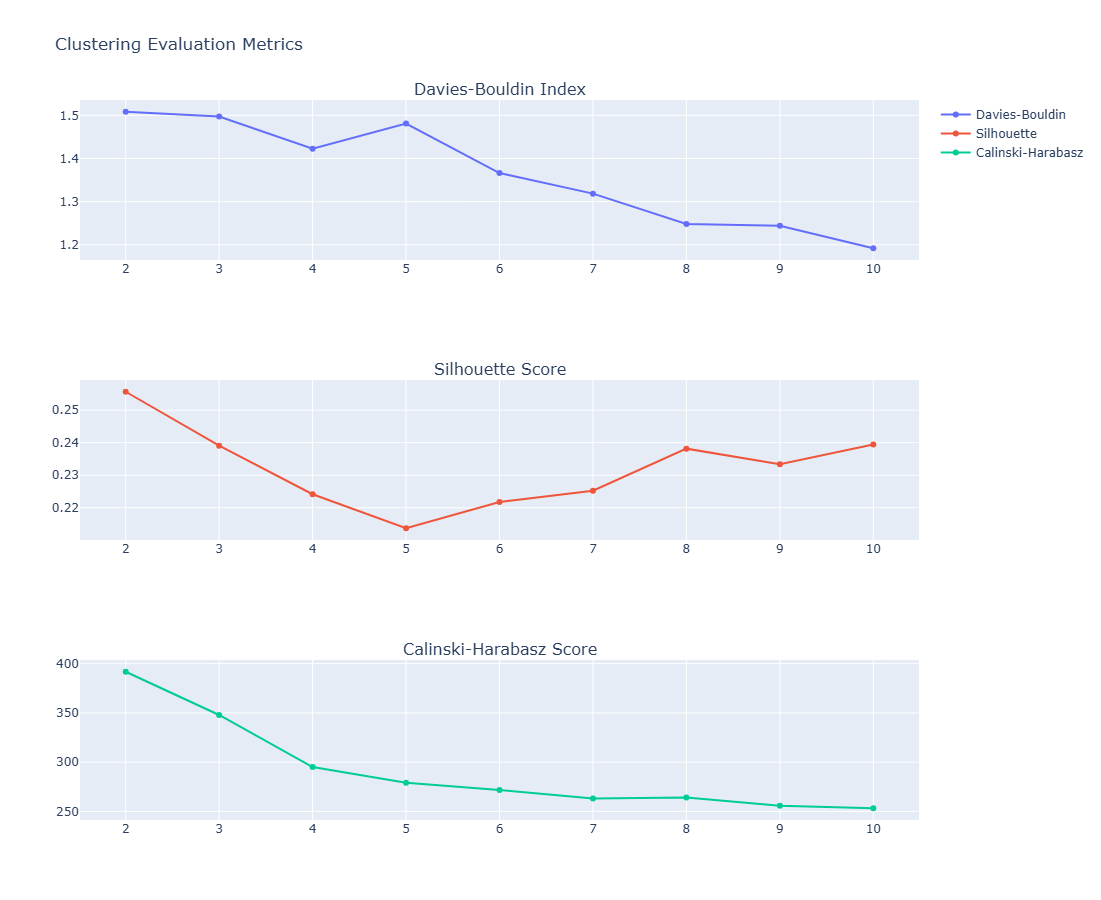

In [15]:
# Evaluate optimal number of clusters
metrics = analysis.evaluate_optimal_clusters(max_clusters=10)
    
    

In [16]:
# Perform clustering with optimal number of clusters
n_clusters = 7  # Choose based on evaluation metrics
clustering_results = analysis.perform_clustering(n_clusters)
    
   

In [17]:
 # Evaluate clustering results
evaluation_metrics = analysis.evaluate_clustering()
print("\nClustering Evaluation Metrics:")
print(evaluation_metrics)
    
   


Clustering Evaluation Metrics:
                    KMeans  DBSCAN  Agglomerative     GMM  Spectral
Davies-Bouldin       1.319   1.322          1.493   2.371     1.284
Silhouette           0.225   0.049          0.186  -0.042     0.195
Calinski-Harabasz  263.044  25.184        229.257  76.290   232.748


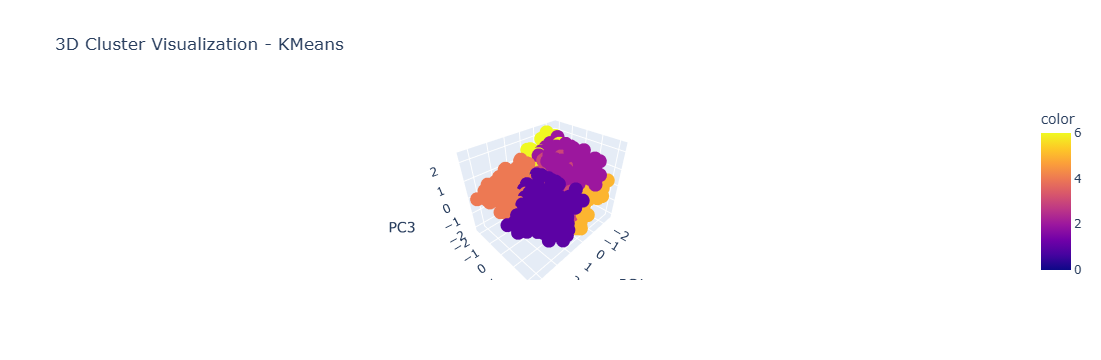

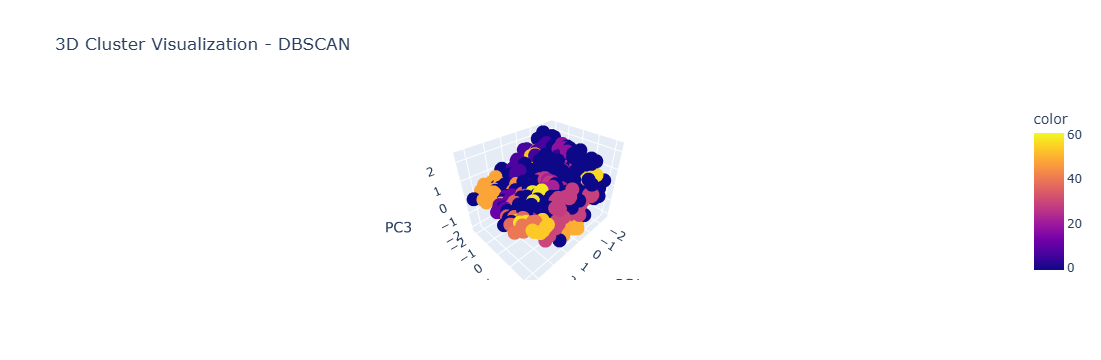

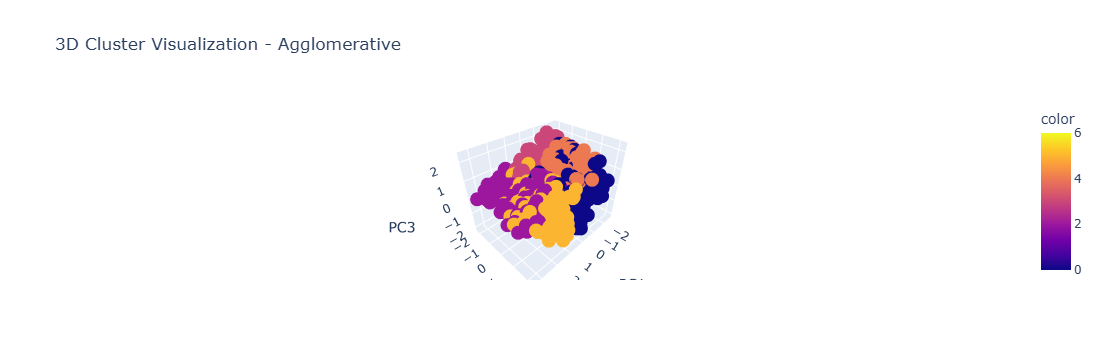

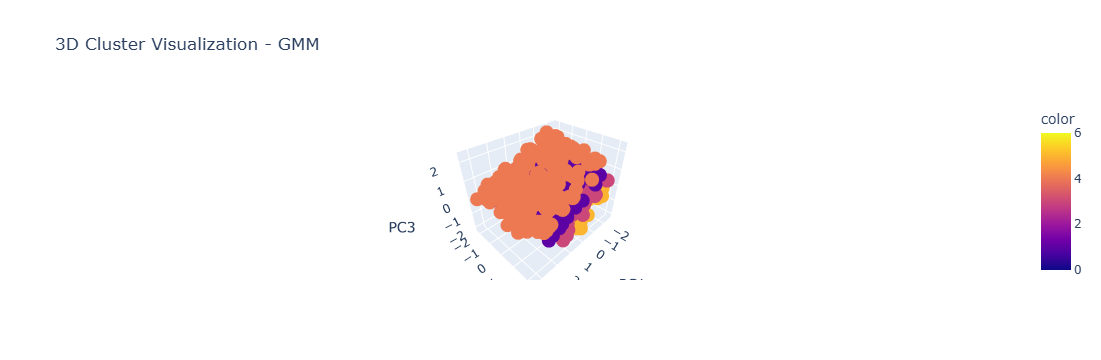

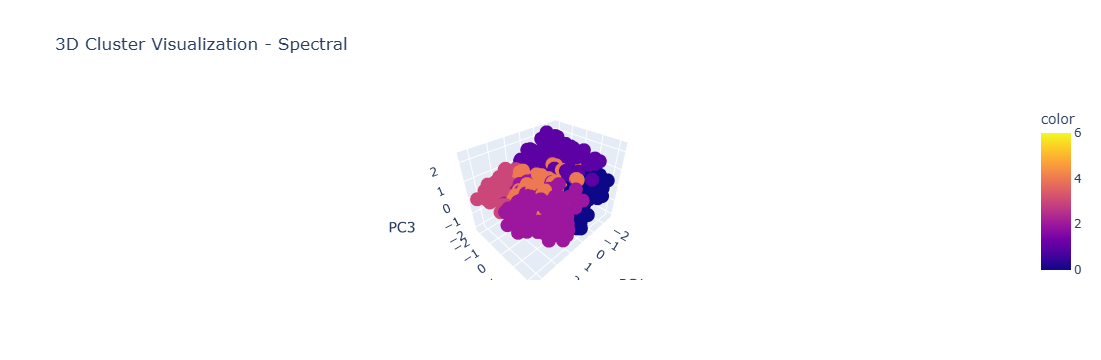

In [18]:
# Visualize clusters in 3D
analysis.visualize_clusters_3d()
    
    


Cluster Summary for KMeans:
        Quantity       TotalValue           Price        
            mean   std       mean     std    mean     std
Cluster                                                  
0           1.49  0.54     573.75  218.68  386.52   67.10
1           3.40  0.62    1203.82  290.66  360.02   78.52
2           3.45  0.50     347.29  194.04  101.72   56.96
3           2.13  0.95     602.23  307.52  297.13  114.15
4           3.65  0.48    1423.90  273.65  392.11   66.43
5           1.41  0.49     237.51  146.39  174.78   98.70
6           2.44  1.03     286.63  214.86  117.97   72.69


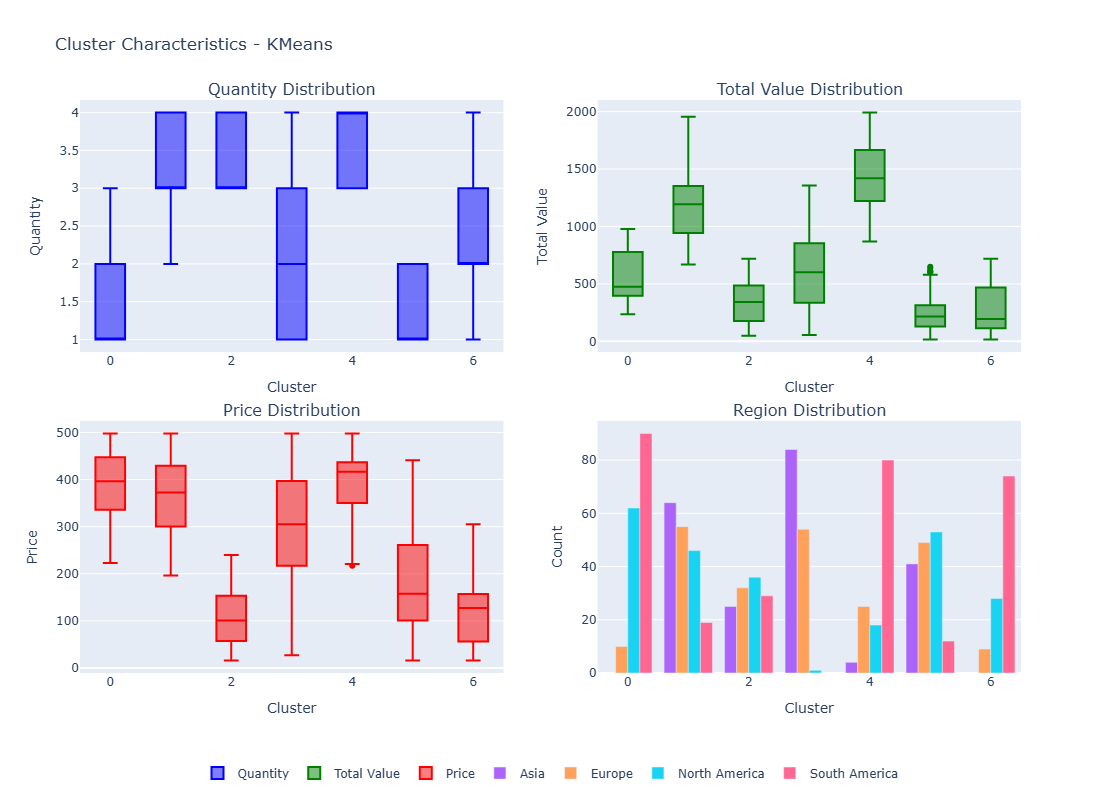


Cluster Summary for DBSCAN:
        Quantity       TotalValue           Price        
            mean   std       mean     std    mean     std
Cluster                                                  
-1          2.81  1.09     673.85  492.41  245.06  148.84
 0          2.00  0.00     107.09   61.49   53.55   30.75
 1          3.00  0.00     420.78   26.00  140.26    8.67
 2          2.00  0.00     738.66  152.95  369.33   76.48
 3          3.00  0.00    1252.63  134.77  417.54   44.92
...          ...   ...        ...     ...     ...     ...
 57         4.00  0.00    1714.01   42.40  428.50   10.60
 58         4.00  0.00    1202.20   93.51  300.55   23.38
 59         1.00  0.00     343.25   57.37  343.25   57.37
 60         2.00  0.00     598.30   69.74  299.15   34.87
 61         3.00  0.00    1319.90   45.21  439.97   15.07

[63 rows x 6 columns]


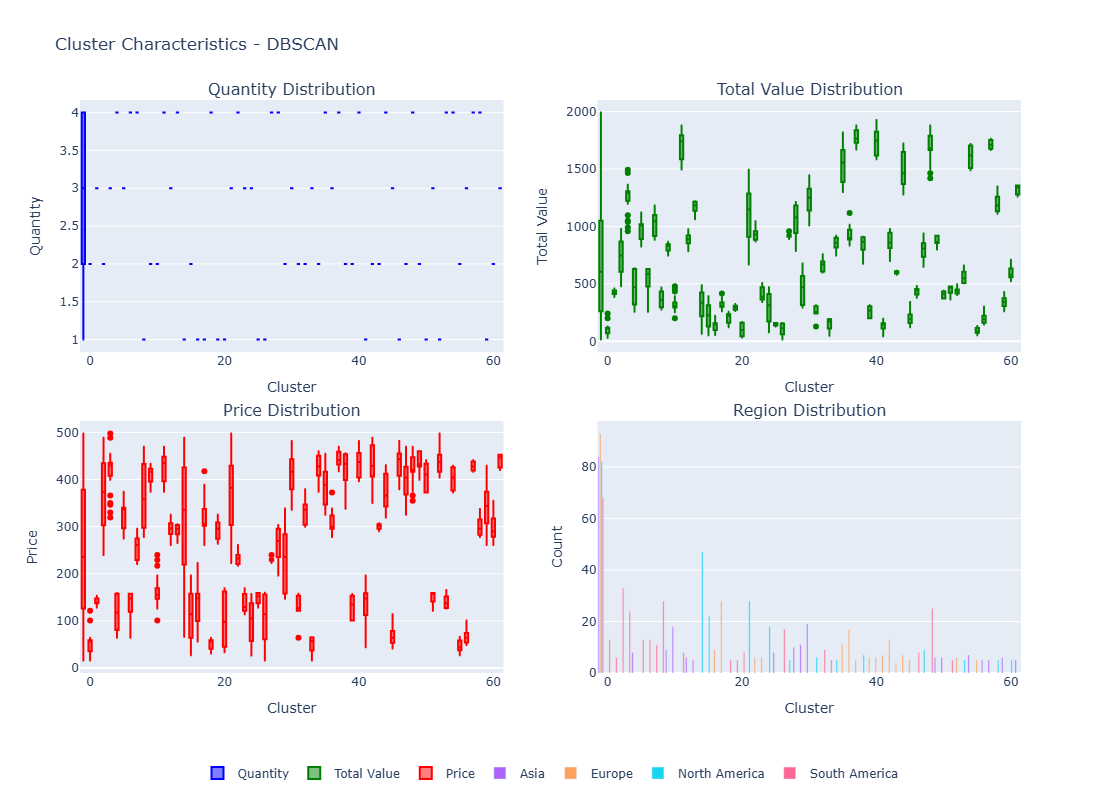


Cluster Summary for Agglomerative:
        Quantity       TotalValue           Price       
            mean   std       mean     std    mean    std
Cluster                                                 
0           2.15  1.10     295.04  203.42  151.93  92.69
1           1.52  0.50     564.11  222.70  369.18  70.76
2           3.52  0.50    1330.60  330.79  377.77  75.09
3           2.85  1.05     420.84  332.71  139.97  89.38
4           2.65  1.05     276.01  176.04  106.79  53.18
5           3.40  0.64    1245.20  275.90  372.11  71.61
6           1.43  0.50     526.99  222.38  367.21  84.18


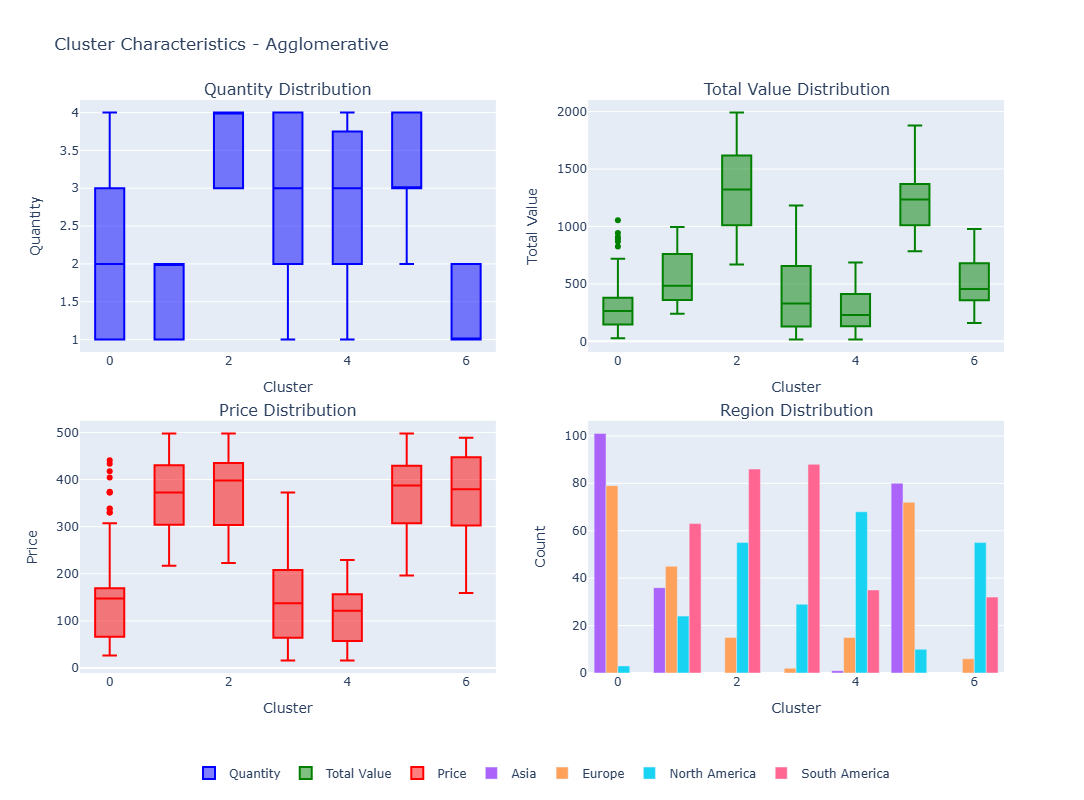


Cluster Summary for GMM:
        Quantity       TotalValue           Price        
            mean   std       mean     std    mean     std
Cluster                                                  
0            2.0  0.00     592.94  279.70  296.47  139.85
1            3.0  0.00     820.99  435.79  273.66  145.26
2            2.0   NaN     128.50     NaN   64.25     NaN
3            2.0  0.00     537.19  286.19  268.60  143.09
4            4.0  0.00    1079.38  554.02  269.84  138.50
5            1.0  0.00     276.63  134.47  276.63  134.47
6            1.5  0.55      90.07   26.87   61.42    4.54


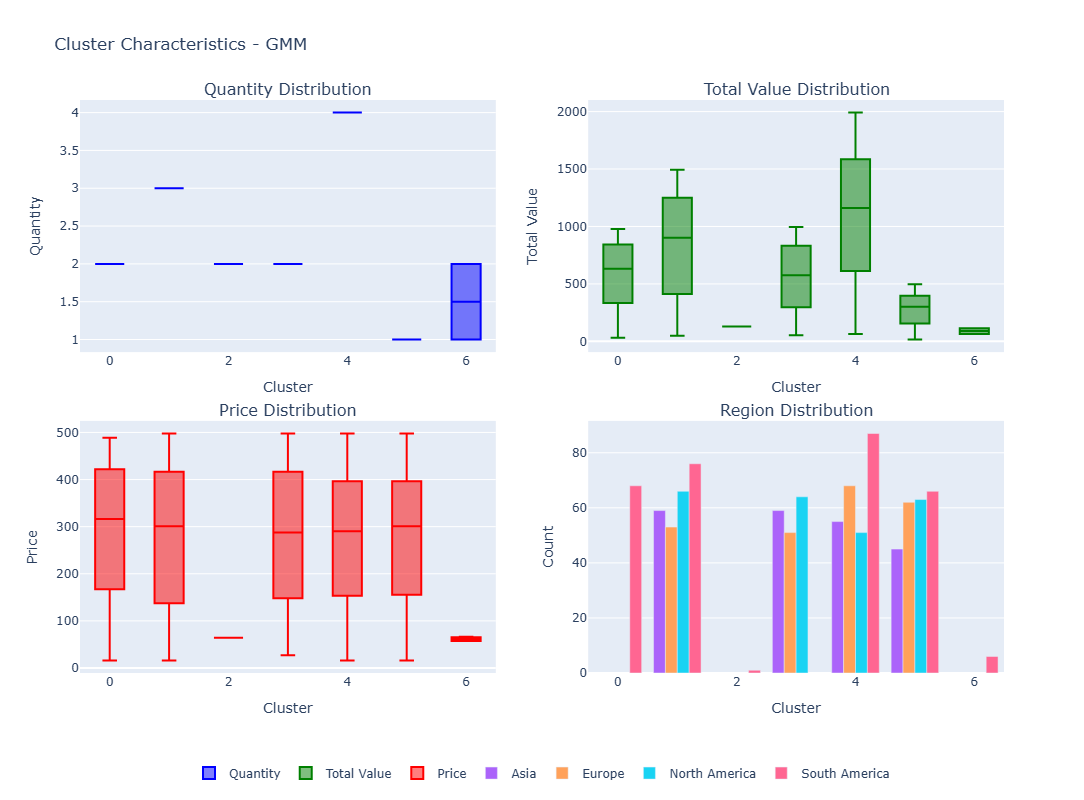


Cluster Summary for Spectral:
        Quantity       TotalValue           Price       
            mean   std       mean     std    mean    std
Cluster                                                 
0           1.59  0.65     232.65  135.09  155.80  89.42
1           3.59  0.49     384.63  236.96  106.75  63.33
2           3.55  0.60    1328.23  296.08  378.33  72.02
3           3.65  0.48    1498.69  241.25  412.79  51.57
4           2.42  1.01     759.98  325.61  331.52  96.62
5           1.67  0.63     141.65   90.43   91.47  54.05
6           1.68  0.65     614.24  237.73  370.54  67.92


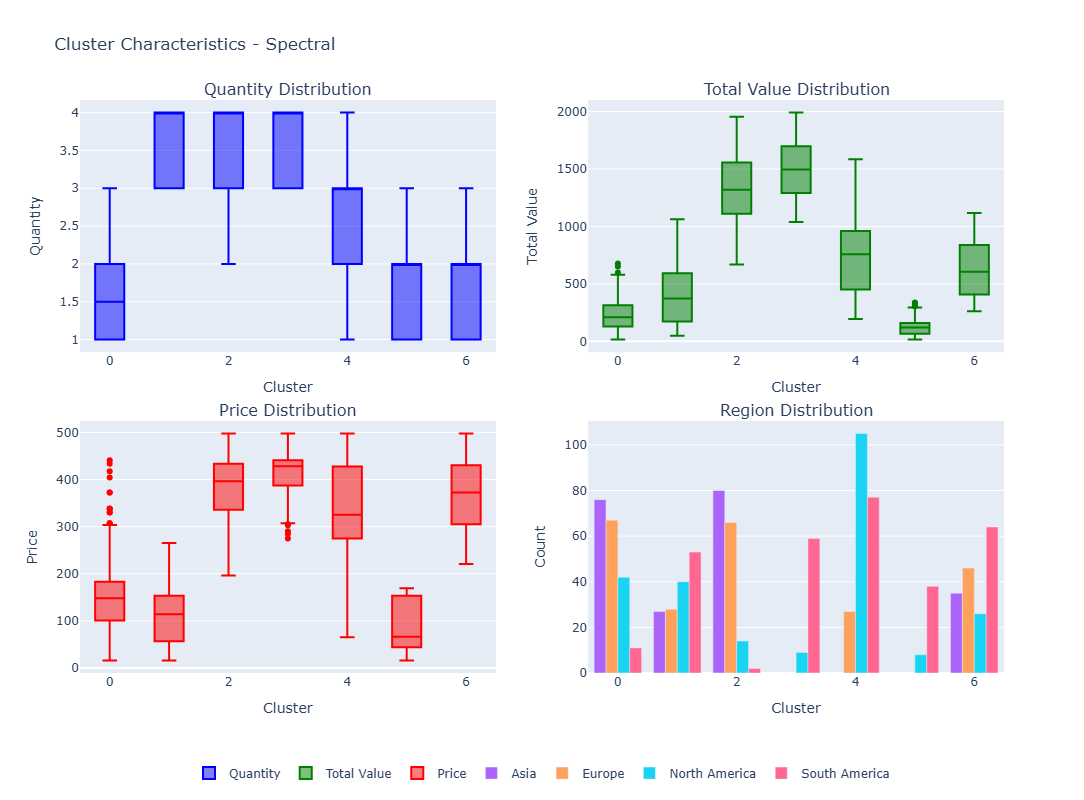

In [19]:
# Analyze cluster characteristics
analysis.analyze_cluster_characteristics()



Model Comparison:
                          KMeans  DBSCAN  Agglomerative     GMM  Spectral
Silhouette Score           0.225   0.049          0.186  -0.042     0.195
Davies-Bouldin Score       1.319   1.322          1.493   2.371     1.284
Calinski-Harabasz Score  263.044  25.184        229.257  76.290   232.748

Best performing model: DBSCAN


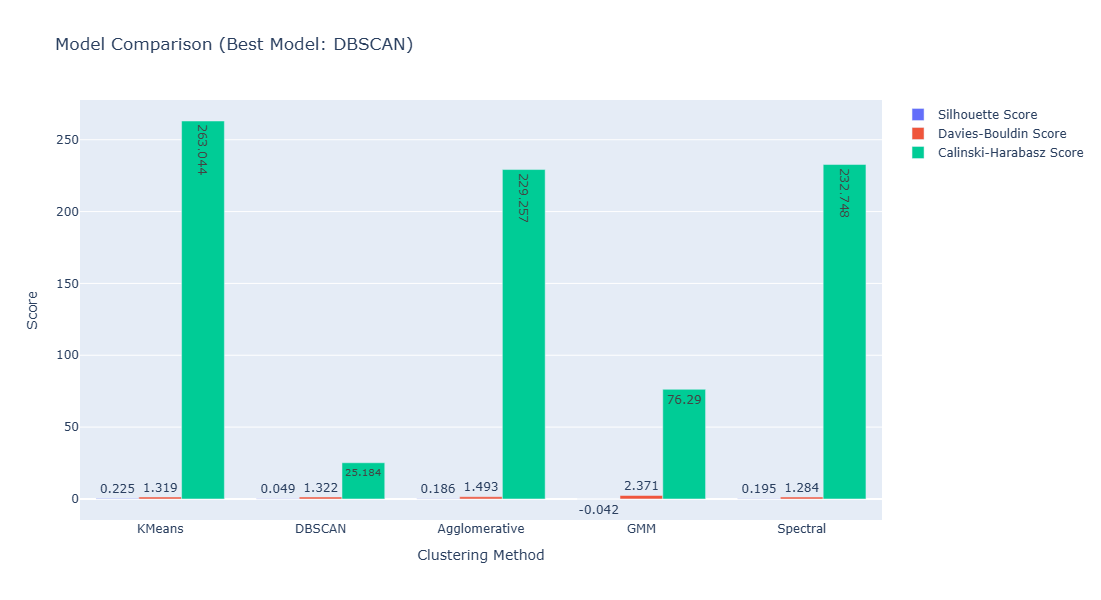

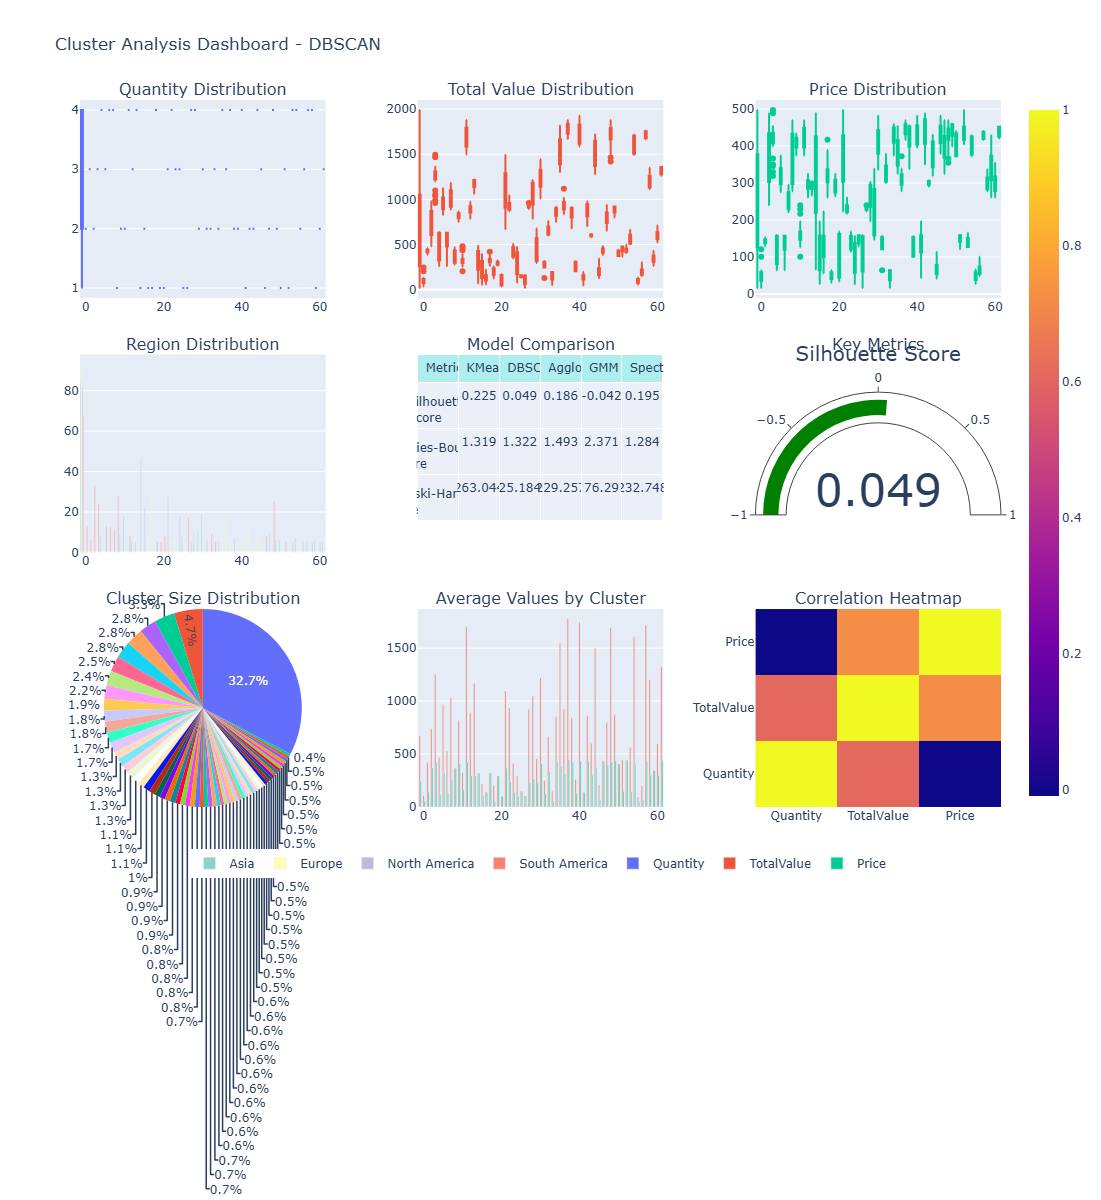

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

class CustomerClusteringAnalysis:
    def __init__(self, customers_path, transactions_path):
        self.customers_path = customers_path
        self.transactions_path = transactions_path
        self.features = None
        self.normalized_data = None
        self.merged_df = None
        self.clustering_results = {}
        self.model_scores = {}

    def load_and_preprocess_data(self):
        # Load data
        customers_df = pd.read_csv(self.customers_path)
        transactions_df = pd.read_csv(self.transactions_path)
        
        # Merge datasets
        self.merged_df = pd.merge(customers_df, transactions_df, on='CustomerID')
        
        # Select features
        self.features = self.merged_df[['Quantity', 'TotalValue', 'Price', 'Region', 'SignupDate']]
        self.features = self.features.dropna()
        
        # Encode categorical features
        label_encoder = LabelEncoder()
        self.features['Region_Encoded'] = label_encoder.fit_transform(self.features['Region'])
        self.features['SignupDate_Numeric'] = pd.to_datetime(self.features['SignupDate']).apply(lambda x: x.toordinal())
        
        # Select numeric features
        numeric_features = self.features[['Quantity', 'TotalValue', 'Price', 'Region_Encoded', 'SignupDate_Numeric']]
        
        # Standardize features
        scaler = StandardScaler()
        self.normalized_data = scaler.fit_transform(numeric_features)
        
        return self.features, self.normalized_data

    def perform_clustering(self, n_clusters):
        """Perform clustering using multiple algorithms and evaluate them"""
        # K-Means
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        self.clustering_results['KMeans'] = kmeans.fit_predict(self.normalized_data)
        
        # DBSCAN
        dbscan = DBSCAN(eps=0.5, min_samples=5)
        self.clustering_results['DBSCAN'] = dbscan.fit_predict(self.normalized_data)
        
        # Agglomerative
        agg = AgglomerativeClustering(n_clusters=n_clusters)
        self.clustering_results['Agglomerative'] = agg.fit_predict(self.normalized_data)
        
        # GMM
        gmm = GaussianMixture(n_components=n_clusters, random_state=42)
        self.clustering_results['GMM'] = gmm.fit_predict(self.normalized_data)
        
        # Spectral
        spectral = SpectralClustering(n_clusters=n_clusters, random_state=42)
        self.clustering_results['Spectral'] = spectral.fit_predict(self.normalized_data)
        
        # Evaluate each model
        for method, labels in self.clustering_results.items():
            self.model_scores[method] = {
                'Silhouette Score': silhouette_score(self.normalized_data, labels),
                'Davies-Bouldin Score': davies_bouldin_score(self.normalized_data, labels),
                'Calinski-Harabasz Score': calinski_harabasz_score(self.normalized_data, labels)
            }
        
        return self.clustering_results

    def create_cluster_dashboard(self, method, labels):
        """Create comprehensive single-view dashboard for cluster analysis"""
        analysis_df = self.features.copy()
        analysis_df['Cluster'] = labels
        
        fig = make_subplots(
            rows=3, cols=3,
            subplot_titles=(
                'Quantity Distribution', 'Total Value Distribution', 'Price Distribution',
                'Region Distribution', 'Model Comparison', 'Key Metrics',
                'Cluster Size Distribution', 'Average Values by Cluster', 'Correlation Heatmap'
            ),
            specs=[
                [{"type": "box"}, {"type": "box"}, {"type": "box"}],
                [{"type": "bar"}, {"type": "table"}, {"type": "indicator", "colspan": 1}],
                [{"type": "pie"}, {"type": "bar"}, {"type": "heatmap"}]
            ],
            vertical_spacing=0.08,
            horizontal_spacing=0.1
        )
        
        # Add distributions
        for i, col in enumerate(['Quantity', 'TotalValue', 'Price']):
            fig.add_trace(
                go.Box(y=analysis_df[col], x=analysis_df['Cluster'],
                      name=col, showlegend=False),
                row=1, col=i+1
            )
        
        # Region distribution
        region_dist = analysis_df.groupby(['Cluster', 'Region']).size().unstack()
        colors = px.colors.qualitative.Set3
        for i, region in enumerate(region_dist.columns):
            fig.add_trace(
                go.Bar(x=region_dist.index, y=region_dist[region],
                      name=region, marker_color=colors[i % len(colors)]),
                row=2, col=1
            )
        
        # Model comparison table
        model_comparison = pd.DataFrame(self.model_scores).round(3)
        fig.add_trace(
            go.Table(
                header=dict(values=['Metric'] + list(model_comparison.columns),
                          fill_color='paleturquoise',
                          align='left'),
                cells=dict(values=[model_comparison.index] + [model_comparison[col] for col in model_comparison.columns]),
            ),
            row=2, col=2
        )
        
        # Key metrics indicator
        silhouette = self.model_scores[method]['Silhouette Score']
        fig.add_trace(
            go.Indicator(
                mode="gauge+number",
                value=silhouette,
                title={'text': "Silhouette Score"},
                gauge={'axis': {'range': [-1, 1]}},
                domain={'row': 1, 'column': 2}
            ),
            row=2, col=3
        )
        
        # Cluster size distribution
        cluster_sizes = analysis_df['Cluster'].value_counts()
        fig.add_trace(
            go.Pie(labels=cluster_sizes.index, values=cluster_sizes.values,
                   showlegend=False),
            row=3, col=1
        )
        
        # Average values by cluster
        avg_values = analysis_df.groupby('Cluster')[['Quantity', 'TotalValue', 'Price']].mean()
        for col in avg_values.columns:
            fig.add_trace(
                go.Bar(x=avg_values.index, y=avg_values[col], name=col),
                row=3, col=2
            )
        
        # Correlation heatmap
        corr_matrix = analysis_df[['Quantity', 'TotalValue', 'Price']].corr()
        fig.add_trace(
            go.Heatmap(
                z=corr_matrix.values,
                x=corr_matrix.columns,
                y=corr_matrix.columns,
                showscale=True
            ),
            row=3, col=3
        )
        
        # Update layout
        fig.update_layout(
            height=1200,
            width=1600,
            title_text=f"Cluster Analysis Dashboard - {method}",
            showlegend=True,
            legend=dict(
                orientation="h",
                yanchor="bottom",
                y=-0.1,
                xanchor="center",
                x=0.5
            )
        )
        
        return fig

    def find_best_model(self):
        """Determine the best performing model based on multiple metrics"""
        scores_df = pd.DataFrame(self.model_scores).round(3)
        
        # Normalize scores (note: Davies-Bouldin score is better when lower)
        normalized_scores = scores_df.copy()
        normalized_scores.loc['Davies-Bouldin Score'] = 1 / normalized_scores.loc['Davies-Bouldin Score']
        normalized_scores = (normalized_scores - normalized_scores.min()) / (normalized_scores.max() - normalized_scores.min())
        
        # Calculate average normalized score
        average_scores = normalized_scores.mean()
        best_model = average_scores.idxmax()
        
        # Create comparison visualization
        fig = go.Figure()
        
        # Add bar plots for each metric
        metrics = scores_df.index
        models = scores_df.columns
        
        for metric in metrics:
            fig.add_trace(
                go.Bar(
                    name=metric,
                    x=models,
                    y=scores_df.loc[metric],
                    text=scores_df.loc[metric].round(3),
                    textposition='auto',
                )
            )
        
        fig.update_layout(
            title=f"Model Comparison (Best Model: {best_model})",
            barmode='group',
            xaxis_title="Clustering Method",
            yaxis_title="Score",
            height=600
        )
        
        return best_model, scores_df, fig

def main():
    # Initialize analysis
    analysis = CustomerClusteringAnalysis("Customers.csv", "Transactions.csv")
    
    # Load and preprocess data
    features, normalized_data = analysis.load_and_preprocess_data()
    
    # Perform clustering
    n_clusters = 7  # You can adjust this based on your needs
    clustering_results = analysis.perform_clustering(n_clusters)
    
    # Find best model
    best_model, scores_df, comparison_fig = analysis.find_best_model()
    print("\nModel Comparison:")
    print(scores_df)
    print(f"\nBest performing model: {best_model}")
    comparison_fig.show()
    
    # Create dashboard for the best model
    best_model_labels = clustering_results[best_model]
    dashboard = analysis.create_cluster_dashboard(best_model, best_model_labels)
    dashboard.show()

if __name__ == "__main__":
    main()

## BEST MODEL ANALYSIS